In [1]:
# Drop duplicates - no changes to detected inconsistencies.

from collections import defaultdict, Counter
from multiprocessing import Pool
from pathlib import Path
from typing import Dict
import json
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from consent.consistency.cookie_pref_match import cookie_pref_match
from consent.consistency.util import SCAN_DIRS, FIG_DIR, SCAN_ROOT_DIR
from consent.data.pref_menu_scan.cookie_pref_reader import read_cookie_prefs_in_scans
from consent.data.pref_menu_scan.log_reader import read_logs_in_scans
from consent.data.pref_menu_scan.cookie_decl_reader import read_cookie_decls_in_scans
from consent.data.pref_menu_scan.postrej_cookie_reader import read_postrej_sent_cookies_in_scans
from consent.util.default_path import get_data_dir
from ooutil.type_util import hashabledict
from ooutil.url_util import get_suffixed_domain

In [2]:
# Get cookie prefs = cookie decls + prefs
cookie_prefs = read_cookie_prefs_in_scans(SCAN_DIRS)
cookie_prefs.head()

Fail to read log 0 sites: []
https://cdn.cookielaw.org/consent/bfc3f6d1-88f6-4292-b5d2-757633a696fe/54ee6350-f89f-49ec-8de3-55e458bcb2e4/en.json WARNING: Cookie list has session cookie but duration > 0
https://cdn-ukwest.onetrust.com/consent/e00c3e10-0e07-461a-94d5-e87b899fa55a/442b5be0-8f10-4555-b6a6-2aa7c2e23dfa/en.json WARNING: Cookie list has session cookie but duration > 0
https://cdn.cookielaw.org/consent/cadb9218-57dc-4d9d-88e2-9f60895ffd8e/c20c2294-be24-4c10-b904-91ccd622468e/en-us.json WARNING: Cookie list has session cookie but duration > 0
https://cdn.cookielaw.org/consent/a3cad216-8692-4702-a85d-06e5c30c35cc/c500ad25-efb5-41be-97d0-530b3cb248d6/en.json WARNING: Cookie list has session cookie but duration > 0
Failed to read cookies on 5: ['eero.com', 'eurail.com', 'fhi360.org', 'marieforleo.com', 'reiss.com']


,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,s-9da4,go.helpshift.com,7 days,C0002,Performance Cookies,inactive,helpshift.com,onetrust,en.json,False
1,_gid,helpshift.com,1 days,C0002,Performance Cookies,inactive,helpshift.com,onetrust,en.json,False
2,blog_glossary_page,helpshift.com,7 days,C0002,Performance Cookies,inactive,helpshift.com,onetrust,en.json,False
3,__utma,helpshift.com,730 days,C0002,Performance Cookies,inactive,helpshift.com,onetrust,en.json,False
4,_ga,helpshift.com,730 days,C0002,Performance Cookies,inactive,helpshift.com,onetrust,en.json,False


In [3]:
cookielist_sites = sorted(cookie_prefs.site.unique().tolist())
n_cookielist_sites = len(cookielist_sites)
assert cookie_prefs.site.nunique() == n_cookielist_sites
n=10
print("Sites with cookie prefs:", n_cookielist_sites, f', first {n} sites:' , cookielist_sites[:n])

Sites with cookie prefs: 1361 , first 10 sites: ['10fastfingers.com', '24hourfitness.com', '24s.com', '2o7.net', '3dmark.com', '3dsystems.com', '451research.com', '4sq.com', 'ab-inbev.com', 'abbvie.com']


In [4]:
# print("Libs in failed-to-crawl sites")
# errors.consent_lib_name.value_counts()

In [5]:
# # Distribution of errors
# from ooutil.df_util import expand_dict_col
# ot_errs = errors[errors.consent_lib_name == 'onetrust']
# errors_dict = pd.DataFrame(ot_errs.error.tolist()).explode('reason')
# # Uncomment to show
# # errors_dict.reason.value_counts()

In [6]:
# ot_errs[ot_errs.site == 'doodle.com'].error.iloc[0]

In [7]:
# ot_errs[ot_errs.error.str.contains('waiting for selector')]

In [8]:
# cb_errs = errors[errors.consent_lib_name == 'cookiebot_legacy']
# cb_errs
# pd.DataFrame(cb_errs.error.tolist()).explode('reason')

# Main analysis

In [9]:
import sys; import importlib; importlib.reload(sys.modules['consent.data.pref_menu_scan.postrej_cookie_reader'])
from consent.data.pref_menu_scan.postrej_cookie_reader import read_postrej_sent_cookies_in_scans


overwrite = False
cookies_cache_file = SCAN_ROOT_DIR / 'raw_postrej_sent_cookies.parquet'

if not overwrite and cookies_cache_file and cookies_cache_file.exists():
    sent_cookies = pd.read_parquet(cookies_cache_file)
else:
    sent_cookies = read_postrej_sent_cookies_in_scans(SCAN_DIRS)
    if cookies_cache_file: sent_cookies.to_parquet(cookies_cache_file); print(f"Written to {cookies_cache_file}")

print(f"Number sent cookies read: {len(sent_cookies):,d}")
sent_cookies.head(3)

Number sent cookies read: 5,196,675


,domain,expires,httpOnly,name,path,sameSite,secure,value,request_url,site,load_start_time,load_end_time,page_url
0,.apachefriends.org,1.629067e+09,False,_gid,/,None,False,GA1.2.720720591.1628980892,https://www.apachefriends.org/images/flags/fr-...,apachefriends.org,1.628981e+09,1.628981e+09,https://www.apachefriends.org/index.html
1,.apachefriends.org,1.660517e+09,False,OptanonAlertBoxClosed,/,Lax,False,2021-08-14T22:42:17.927Z,https://www.apachefriends.org/javascripts/all-...,apachefriends.org,1.628981e+09,1.628981e+09,https://www.apachefriends.org/index.html
2,.apachefriends.org,1.660517e+09,False,OptanonConsent,/,Lax,False,isIABGlobal=false&datestamp=Sat+Aug+14+2021+22...,https://www.apachefriends.org/images/flags/fr-...,apachefriends.org,1.628981e+09,1.628981e+09,https://www.apachefriends.org/index.html


In [10]:
# prj = post-rejection
prj_sent_cookies = sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'value', 'request_url', 'site']].drop_duplicates()
prj_br_cookies = prj_sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'site']].drop_duplicates()

In [11]:
print(f"Num captured sent cookies: {len(sent_cookies):,d}")
print(f"Num unique captured cookies: {len(prj_sent_cookies):,d}")
n_br_cookies = len(prj_br_cookies)
print(f"Num unique browser cookies: {n_br_cookies:,d} on {prj_br_cookies.site.nunique():,d} websites and {sent_cookies.page_url.nunique():,d} pages")

Num captured sent cookies: 5,196,675
Num unique captured cookies: 3,128,463
Num unique browser cookies: 75,829 on 1,360 websites and 7,750 pages


## Analyze cookies compliance    

In [13]:
# Map intercepted cookies to browser cookies.
import sys; import importlib; importlib.reload(sys.modules['consent.consistency.cookie_pref_match'])
from consent.consistency.cookie_pref_match import cookie_pref_match

site_to_contras = {}  # TODO: make this to non-global one.

def check_in_set(site, acookie, cookie_pref_set, verbose=0):
    # check_url_host_match = relax_check_url_host_match # strict_check_url_host_match
    # Faster here.
    for cookie_pref in cookie_pref_set:
        if verbose >= 3:
            print(f'{cookie_pref=} {acookie=}')
        elif verbose >= 2:
            if cookie_pref['name'] == acookie['name']:
                print(f'{cookie_pref=} {acookie=}')
        
        if cookie_pref_match(acookie, cookie_pref, site):
            return True
    return False


def comply_check(site, acookie, appr_set, rej_set):
    is_appr = check_in_set(site, acookie, appr_set)
    is_rej = check_in_set(site, acookie, rej_set)
    if is_appr and not is_rej:
        return 'comply'
    elif not is_appr and is_rej:
        return 'incorrect'
    elif not is_appr and not is_rej:
        return 'omit'
    else:
        return 'ambiguous'


def get_appr_rej_sets(prefs):
    """Return 2 sets: appr and rejection."""
    def get_hashable_cookie_set(df):
        cookies = df[['domain', 'name']].to_dict('records')
        return set(hashabledict(c) for c in cookies)
    
    appr_set = get_hashable_cookie_set(prefs[prefs.consent == True])
    rej_set = get_hashable_cookie_set(prefs[prefs.consent == False])
    assert len(prefs[~prefs.consent.isin([True, False])]) == 0
    
    contra_set = appr_set.intersection(rej_set)

    return appr_set, rej_set, contra_set


def _get_comply_for_site(site, prefs, sent_cookies):
    appr_set, rej_set, contra_set = get_appr_rej_sets(prefs)
    comply_results = []
    for sent_cookie in sent_cookies:
        comply = comply_check(site, sent_cookie, appr_set, rej_set)
        comply_result = sent_cookie.copy()
        comply_result.update({'comply': comply, 'site': site})
        comply_results.append(comply_result)
    if len(contra_set) > 0:
        site_to_contras[site] = contra_set
        if len(site_to_contras) < 20: # Print some of the contra to see the progress only
            print(f'Contradictory set: {site=} {contra_set=}')    
    return comply_results

def get_comply_for_sites(args, sites, parallel=False):
    if parallel: # not work, maybe bottleneck is the transfer of a big data frame.
        pool = Pool(32)
        for result in pool.starmap(_get_comply_for_site, args):
            yield result
    else:
        for arg in tqdm(args, total=len(sites)):
            yield _get_comply_for_site(*arg)
            
def get_compute_args(sites, cookie_prefs, prj_sent_cookies):
    #     return [(site, cookie_prefs, prj_sent_cookies) for site in sites]
    for site in sites:
        site_cookie_prefs = cookie_prefs[cookie_prefs.site == site]
        site_prj_sent_cookies = prj_sent_cookies[prj_sent_cookies.site == site].to_dict('records')   
        yield site, site_cookie_prefs, site_prj_sent_cookies
            
def get_comply(cookie_prefs, prj_sent_cookies):
    sites = cookie_prefs.site.unique() # .tolist()
#     sites = ['suse.com', 'ulta.com', 'optimizely.com', 'cell.com']
    args = get_compute_args(sites, cookie_prefs, prj_sent_cookies)
    
    comply_results = []    
    for complies_for_site in get_comply_for_sites(args, sites, parallel=False):
        comply_results.extend(complies_for_site)
        
    return pd.DataFrame(comply_results)
    
# Try to drop duplicates to see any difference in result.
cookie_prefs = cookie_prefs.drop_duplicates()
prj_sent_cookies = prj_sent_cookies.drop_duplicates()

print("faster: for cookie_pref in cookie_pref_set[cookie_pref_set.name == acookie['name']]:")
all_complies = get_comply(cookie_prefs, prj_sent_cookies)
all_complies.head()

faster: for cookie_pref in cookie_pref_set[cookie_pref_set.name == acookie['name']]:


  0%|          | 5/1361 [00:02<14:09,  1.60it/s]

Contradictory set: site='ulta.com' contra_set={{'domain': 'ulta.com', 'name': '_schn'}}


  2%|▏         | 21/1361 [00:10<12:52,  1.73it/s]

Contradictory set: site='suse.com' contra_set={{'domain': 'scc.suse.com', 'name': '_glue_session'}, {'domain': 'buy.suse.com', 'name': 'AWSELB'}}


  3%|▎         | 37/1361 [00:18<09:14,  2.39it/s]

Contradictory set: site='optimizely.com' contra_set={{'domain': 'optimizely.com', 'name': '__tld__'}}


  3%|▎         | 39/1361 [00:18<07:19,  3.01it/s]

Contradictory set: site='cell.com' contra_set={{'domain': 'hubspot.net', 'name': '__cfduid'}}


  4%|▍         | 58/1361 [00:26<09:52,  2.20it/s]

Contradictory set: site='ebsco.com' contra_set={{'domain': 'connect.ebsco.com', 'name': 'pctrk'}}


  4%|▍         | 61/1361 [00:29<16:26,  1.32it/s]

Contradictory set: site='adobeconnect.com' contra_set={{'domain': 'app-aba.marketo.com', 'name': '__cf_bm'}, {'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}}


  5%|▍         | 62/1361 [00:29<13:20,  1.62it/s]

Contradictory set: site='returnpath.net' contra_set={{'domain': 'app.jazz.co', 'name': 'SF_PHPSESSID'}, {'domain': 'community.validity.com', 'name': 'cookieTest'}}


  6%|▌         | 76/1361 [00:34<09:45,  2.19it/s]

Contradictory set: site='aon.com' contra_set={{'domain': 'sleeknotestaticcontent.sleeknote.com', 'name': 'SNS'}, {'domain': 'insights.humancapital.aon.com', 'name': 'ufentry'}}


  6%|▌         | 83/1361 [00:37<07:48,  2.73it/s]

Contradictory set: site='statista.com' contra_set={{'domain': 'm6r.eu', 'name': 'id'}}


  6%|▋         | 88/1361 [00:38<07:10,  2.96it/s]

Contradictory set: site='currys.co.uk' contra_set={{'domain': 'www.currys.co.uk', 'name': 'cookietest'}}


  7%|▋         | 92/1361 [00:43<23:46,  1.12s/it]

Contradictory set: site='meraki.com' contra_set={{'domain': 'cisco.com', 'name': '_vapi'}}


  7%|▋         | 94/1361 [00:49<45:30,  2.16s/it]

Contradictory set: site='magentocommerce.com' contra_set={{'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}}


  7%|▋         | 98/1361 [00:52<22:53,  1.09s/it]

Contradictory set: site='betfair.com' contra_set={{'domain': 'lpcdn.lpsnmedia.net', 'name': 'lpTestCookiennnnnnnn'}, {'domain': 'support.betfair.com', 'name': 'lpTestCookiennnnnnnn'}}


  7%|▋         | 99/1361 [00:55<31:48,  1.51s/it]

Contradictory set: site='vmware.com' contra_set={{'domain': 'communities.vmware.com', 'name': 'LithiumCookiesAccepted'}, {'domain': 'communities.vmware.com', 'name': 'VISITOR_BEACON'}}


  7%|▋         | 101/1361 [00:56<20:23,  1.03it/s]

Contradictory set: site='frontiersin.org' contra_set={{'domain': 'zendesk.frontiersin.org', 'name': 'cf_chl_seq_xxxxxxxxxxxxxxx'}}


  8%|▊         | 107/1361 [00:58<09:18,  2.25it/s]

Contradictory set: site='demdex.net' contra_set={{'domain': 'app-aba.marketo.com', 'name': '__cf_bm'}, {'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}}


  8%|▊         | 113/1361 [01:06<37:27,  1.80s/it]

Contradictory set: site='magento.com' contra_set={{'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}}


  9%|▊         | 116/1361 [01:07<16:50,  1.23it/s]

Contradictory set: site='gmu.edu' contra_set={{'domain': '25livepub.collegenet.com', 'name': 'BIGipServerp-web.25livepub-web.collegenet.com-get'}}


 10%|▉         | 131/1361 [01:15<12:55,  1.59it/s]

Contradictory set: site='2o7.net' contra_set={{'domain': 'app-aba.marketo.com', 'name': '__cf_bm'}, {'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}}


100%|██████████| 1361/1361 [10:24<00:00,  2.18it/s]


,domain,expires,name,path,sameSite,secure,value,request_url,site,comply
0,.helpshift.com,1.628898e+09,content,/,None,False,undefined,https://www.helpshift.com/legal/privacy/,helpshift.com,omit
1,.helpshift.com,1.628898e+09,_gid,/,None,False,GA1.2.1458316132.1628811394,https://www.helpshift.com/legal/privacy/,helpshift.com,incorrect
2,.helpshift.com,1.628898e+09,content,/,None,False,undefined,https://go.helpshift.com/js/forms2/js/forms2.m...,helpshift.com,omit
3,.helpshift.com,1.628812e+09,_gat_UA-97262315-1,/,None,False,1,https://cdn.helpshift.com/wp-content/litespeed...,helpshift.com,omit
4,.helpshift.com,1.660347e+09,OptanonConsent,/,Lax,False,isIABGlobal=false&datestamp=Thu+Aug+12+2021+23...,https://www.helpshift.com/wp-content/litespeed...,helpshift.com,omit


In [16]:
# Record the analysis results
all_complies_file = SCAN_ROOT_DIR / 'all_complies.parquet'
all_complies.to_parquet(all_complies_file); print(f"Written {len(all_complies):,d} records of all_complies to {all_complies_file}")

Written 3120260 records of all_complies to /mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2021-08-12/all_complies.parquet


In [14]:
detected_contra_sites = [s for s, contras in site_to_contras.items() if len(contras) > 0]; len(detected_contra_sites)

140

In [15]:
nsites = all_complies.site.nunique(); nsites

1355

In [16]:
complies = all_complies[ ['name', 'domain', 'site', 'comply',]].drop_duplicates()
comply_counts = complies.comply.value_counts()
comply_counts

omit         21863
incorrect    13857
comply        8290
ambiguous      116
Name: comply, dtype: int64

In [17]:
def get_site_comply_type(site_complies):
    assert site_complies.site.nunique() == 1
    site = site_complies.site.unique()[0]
    site_comply_counts = site_complies.comply.value_counts().to_dict()
    if all(site_comply_counts.get(cp_type, 0) == 0 for cp_type in ['omit', 'incorrect', 'ambiguous']):
        assert site_comply_counts.get('comply', 0) > 0, f'{site} has no comply cookie flows'
        return 'comply'
    if site_comply_counts.get('incorrect', 0) > 0:
        return 'incorrect'
    if site_comply_counts.get('omit', 0) > 0:
        return 'exp_omit'
    if site_comply_counts.get('ambiguous', 0) > 0:
        return 'exp_ambiguous'    
    return None
        
def get_comply_sites(complies_df):
    site_comply_data = []
    for site in all_complies.site.unique():
        site_complies_df = complies_df[ complies_df.site == site ]
        site_comply_data.append({
            'site': site,
            'comply': get_site_comply_type(site_complies_df)
        })
    return pd.DataFrame(site_comply_data)

site_comly_df = get_comply_sites(complies)        

In [18]:
# only consider incorrect and comply
site_comply_counts = site_comly_df.comply.value_counts()
site_comply_counts 

incorrect    1126
exp_omit      169
comply         60
Name: comply, dtype: int64

In [19]:
comply_sites_data = defaultdict(list)
for comply_type, group in complies.groupby('comply'):
    if comply_type in ['incorrect', 'comply']:
        n_sites = site_comply_counts.to_dict().get(comply_type, 0)
    else:
        n_sites = group.site.nunique()
    comply_sites_data['comply_type'].append(comply_type)
    comply_sites_data['num_sites'].append(n_sites)

    comply_sites = pd.DataFrame(comply_sites_data).sort_values(by=['num_sites'], ascending=False)
    

comply_sites['num_sites_percent'] = comply_sites['num_sites'] / nsites * 100
comply_sites['num_cookies'] = comply_sites['comply_type'].map(comply_counts)
comply_sites['num_cookies_percent'] = comply_sites['num_cookies'] / n_br_cookies * 100
comply_sites['num_cookies_per_site'] = comply_sites['num_cookies'] / comply_sites['num_sites'] 

noncomply_sites = comply_sites[comply_sites.comply_type != 'comply']
comply_sites

,comply_type,num_sites,num_sites_percent,num_cookies,num_cookies_percent,num_cookies_per_site
3,omit,1230,90.774908,21863,28.831977,17.774797
2,incorrect,1126,83.099631,13857,18.274011,12.306394
1,comply,60,4.428044,8290,10.932493,138.166667
0,ambiguous,52,3.837638,116,0.152976,2.230769


In [19]:
latex = comply_sites[['comply_type', 'num_cookies', 'num_sites', 'num_sites_percent']].copy()
# latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites']} ({row['num_sites_percent']:.2f}%)", axis=1)
latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites_percent']:.2f}% ({row['num_sites']}/{n_cookielist_sites})", axis=1)
latex = latex[['comply_type', 'num_cookies', 'num_sites_combine']]
latex = latex.rename(columns={'comply_type': '(Non)compliance Type', 'num_sites_combine': '# Websites', 'num_cookies': '# Cookies'})
latex = latex.replace({'omit': "Omitted Preference", "incorrect": "Incorrect Enforcement", "ambiguous": "Ambiguous Enforcement", "comply": "Complied Enforcement"})
print(latex.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
 (Non)compliance Type &  \# Cookies &         \# Websites \\
\midrule
   Omitted Preference &      21863 & 90.77\% (1230/1361) \\
Incorrect Enforcement &      13857 & 83.10\% (1126/1361) \\
 Complied Enforcement &       8290 &    4.43\% (60/1361) \\
Ambiguous Enforcement &        116 &    3.84\% (52/1361) \\
\bottomrule
\end{tabular}



# Analyze contras

In [20]:
# Way 1: compute contra sites by dynamic analysis: this should be lower than statically analyzing prefs
# because we cannot check all combinations of consent modes.
contra_data = []
for asite in cookie_prefs.site.unique():
    site_prefs = cookie_prefs[cookie_prefs.site == asite]
    _, _, contras = get_appr_rej_sets(site_prefs)
    for contra in contras:
        contra['site'] = asite
        contra_data.append(contra)
contra_sites = pd.DataFrame(contra_data)
contra_sites.head()

,domain,name,site
0,ulta.com,_schn,ulta.com
1,scc.suse.com,_glue_session,suse.com
2,buy.suse.com,AWSELB,suse.com
3,optimizely.com,__tld__,optimizely.com
4,hubspot.net,__cfduid,cell.com


In [71]:
assert set(detected_contra_sites) == set(contra_sites.site), "this is the same method with above, so the result"

In [23]:
# Way 2: compute contra sites by DataFrame group by
contra_cookies_dfs = []
for _, same_cookies in cookie_prefs.groupby(['name', 'domain', 'site']):
    consent_modes = same_cookies.consent_mode.unique()
    if len(consent_modes) >= 2 and same_cookies.category.nunique() > 1: # and 'always active' in consent_modes:
        contra_cookies_dfs.append(same_cookies)
contra_cookies = pd.concat(contra_cookies_dfs).drop_duplicates()

In [24]:
set(contra_cookies.site) - set(contra_sites.site)

{'elsevier.nl', 'scirus.com'}

In [76]:
print("Num contra cookie settings (double categories):", len(contra_cookies), f"settings  on {contra_cookies.site.nunique()} sites")
print("Contras with 1 always-active:", contra_sites.site.nunique())
print("Contras with both editable:", len(set(contra_cookies.site) - set(contra_sites.site)))

Num contra cookie settings (both categories): 434 settings  on 142 sites
Contras with 1 always-active: 140
Contras with both editable: 2


In [26]:
contra_cookies[contra_cookies.site == 'elsevier.nl']

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
18,__insp_nv,www.elsevier..com,365 days,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
45,__insp_nv,www.elsevier..com,365 days,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False
20,__insp_targlpt,www.elsevier..com,365 days,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
44,__insp_targlpt,www.elsevier..com,365 days,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False
1,_gtld,elsevier.com,Session,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
5,_gtld,elsevier.com,Session,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False


In [27]:
# assert len(detected_contra_sites) <= contra_sites.site.nunique() < len(detected_contra_sites) + 2

In [28]:
complies[complies.comply == 'ambiguous']

,name,domain,site,comply
53857,CountryCode,.agilent.com,agilent.com,ambiguous
58913,AWSELB,buy.suse.com,suse.com,ambiguous
151148,fg,.adobe.com,adobeconnect.com,ambiguous
151149,feds_visitor_id,.adobe.com,adobeconnect.com,ambiguous
151159,feds_visitor_audience,.adobe.com,adobeconnect.com,ambiguous
...,...,...,...,...
2685275,ASP.NET_SessionId,www.loqate.com,postcodeanywhere.co.uk,ambiguous
2735001,SF_PHPSESSID,app.jazz.co,validity.com,ambiguous
2762382,cbt-consent-banner,www.tommybahama.com,tommybahama.com,ambiguous
2959647,rCookie,.danielwellington.com,danielwellington.com,ambiguous


In [29]:
cookie_prefs[ (cookie_prefs.site == 'michaels.com') & (cookie_prefs.name == 'utag_main') ]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
88,utag_main,.michaels.com,365 days,C0001,Strictly Necessary Cookies,always active,michaels.com,onetrust,en.json,True
13,utag_main,michaels.com,365 days,C0002,Performance Cookies,active,michaels.com,onetrust,en.json,False


In [30]:
cookie_prefs[ (cookie_prefs.site == 'statista.com') & (cookie_prefs.name == 'id') ]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
32,id,m6r.eu,90 days,C0001,Necessary Cookies,always active,statista.com,onetrust,en.json,True
22,id,m6r.eu,0 days,C0004,Targeting Cookies,inactive,statista.com,onetrust,en.json,False


In [68]:
# contra_cookies.name.value_counts()[:10]
# contra_cookies[contra_cookies.name == '__cf_bm'].reset_index(drop=True) # .site.nunique()

# Analyze ambiguous flows

In [94]:
ambi_cookies = complies[complies.comply == 'ambiguous']
print("Num ambiguous cookies:", len(ambi_cookies), "on num sites:", ambi_cookies.site.nunique())
assert len(ambi_cookies) == len(ambi_cookies.drop_duplicates()), "there is some duplicate cookies"


Num ambiguous cookies: 116 on num sites: 52


## Analyze no-way-to-opt-out

In [33]:
# Way 1: compute contra sites by DataFrame group by
nwtoo_cookies_dfs = []
for _, site_cookies in cookie_prefs.groupby(['site']):
    consent_modes = site_cookies.consent_mode.unique().tolist()
    if len(consent_modes) == 1 and consent_modes[0] == 'always active':
        nwtoo_cookies_dfs.append(site_cookies)
nwtoo_cookies = pd.concat(nwtoo_cookies_dfs).drop_duplicates()
nwtoo_cookies.head()

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,OptanonConsent,hybridtheory.com,365 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
1,OptanonAlertBoxClosed,hybridtheory.com,365 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
2,eupubconsent,hybridtheory.com,365 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
0,__cfduid,onetrust.com,4036 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
1,__cfduid,permutive.com,4036 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True


In [34]:
nwtoo_cookies.site.nunique()

65

# Analyze inconsistent flows/cookies

In [37]:
def plot_inconsis_types():
    sns.set(rc={'figure.figsize':(9,9),"font.size":30,"axes.titlesize":30,"axes.labelsize":30},style="white", font_scale = 2.5)

    ax = sns.barplot(x='comply_type', y='num_sites_percent', data=noncomply_sites)
    ax.tick_params(left=True, bottom=True, direction="in")
    ax.set_ylabel('# Websites (%)')
    ax.set_xlabel('Noncompliance Types')
    xticks = [x.get_text().title() for x in ax.get_xticklabels()]
    ax.set(xticklabels=xticks)

    out_file = FIG_DIR / 'noncomply_types_per_site.png'
    # plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [38]:
## Plot distribution of omitted cookie declarations

In [39]:
omit_complies = complies[(complies.comply == 'omit')] #  & ~complies.name.isin(['OptanonAlertBoxClosed', 'OptanonConsent']) ]
omit_complies.site.nunique()

1230

In [40]:
omit_complies.site.value_counts()[:7]

annarbor.com             354
tcpalm.com               284
correio24horas.com.br    280
chieftain.com            266
dispatch.com             256
savannahnow.com          245
sj-r.com                 242
Name: site, dtype: int64

In [41]:
omit_cookies = omit_complies.name.value_counts()[:5].to_frame().reset_index().rename(columns={'index': 'cookie_name'})
omit_cookies['num_sites'] = omit_cookies['cookie_name'].map(lambda cookie_name: omit_complies[omit_complies.name == cookie_name].site.nunique())
print(omit_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))

\begin{tabular}{lr}
\toprule
          Cookie Name &  \# Websites \\
\midrule
              \_gcl\_au &         532 \\
       OptanonConsent &         227 \\
OptanonAlertBoxClosed &         225 \\
                  \_ga &         198 \\
                 \_gid &         196 \\
\bottomrule
\end{tabular}



In [88]:
# set(cookielist_sites) - set(omit_complies.site.unique())
omit_counts = omit_complies.site.value_counts().to_frame().rename(columns={'site': 'num_omit_cookies'})
print("Num omitted sites:", omit_complies.site.nunique())
omit_counts.num_omit_cookies.mean(), omit_counts.num_omit_cookies.std(), omit_counts.num_omit_cookies.min(), omit_counts.num_omit_cookies.max()

Num omitted sites: 1230


(17.77479674796748, 33.04235291265167, 1, 354)

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/omit_cookie_cdf.png


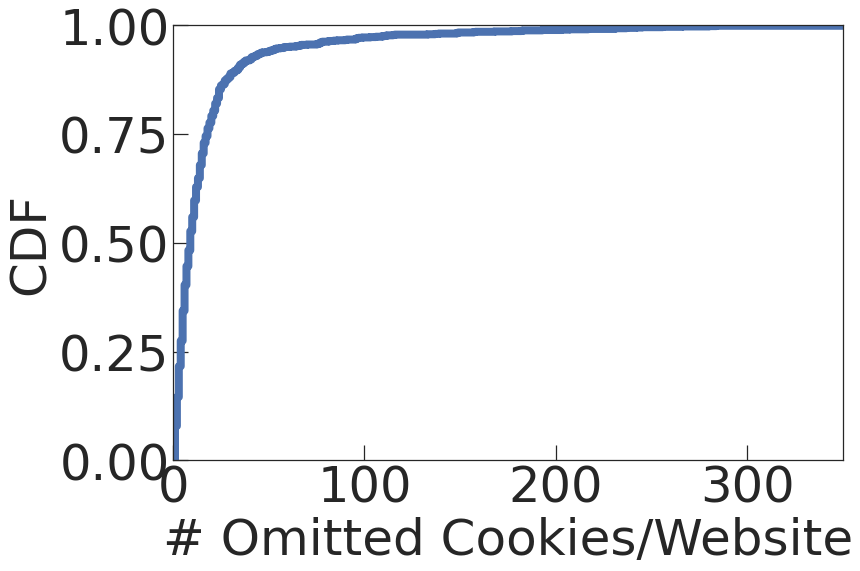

In [93]:
sns.set(rc={'figure.figsize':(12,8),"font.size":35,"axes.titlesize":30,"axes.labelsize":50},style="white", font_scale = 4.5)
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

ax = sns.ecdfplot(data=omit_counts, x=omit_counts.num_omit_cookies, linewidth=8)
ax.set(xlim=(0, 350))

plt.xlabel('# Omitted Cookies/Website')
plt.ylabel('CDF')
out_file = FIG_DIR / 'omit_cookie_cdf.png'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/omit_site.png


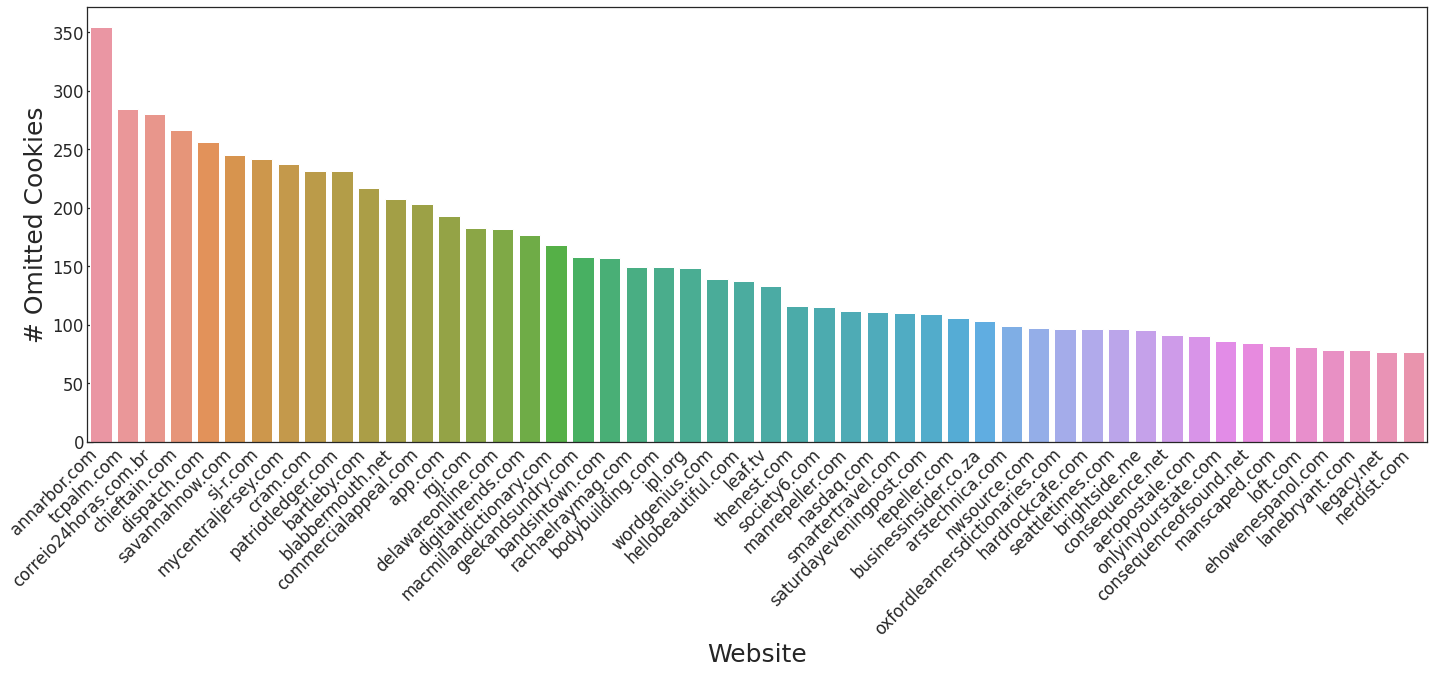

In [135]:
plot_df = omit_counts[:50]

sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x=plot_df.index, y=plot_df.num_omit_cookies)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Omitted Cookies')
ax.set_xlabel('Website')

out_file = FIG_DIR / 'omit_site.png'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [51]:
def plot_histogram_omit():
    sns.set(rc={'figure.figsize':(9,6),"font.size":25,"axes.titlesize":25,"axes.labelsize":15},style="white", font_scale = 1)
    omit_counts_histo = omit_complies.site.value_counts().value_counts()
    sns.barplot(x=omit_counts_histo.index, y=omit_counts_histo.values)
    ticks = plt.xticks(rotation=45, ha='right')

## Plot distribution of incorrectly enforced cookies

In [52]:
incor_complies = complies[complies.comply == 'incorrect']
# set(cookielist_sites) - set(omit_complies.site.unique())
incor_counts = incor_complies.site.value_counts().iloc[:50]
incor_counts = incor_counts.to_frame().reset_index().sort_values(by=['site', 'index'], ascending=[False, True])
incor_counts.columns

Index(['index', 'site'], dtype='object')

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/incor_site.png


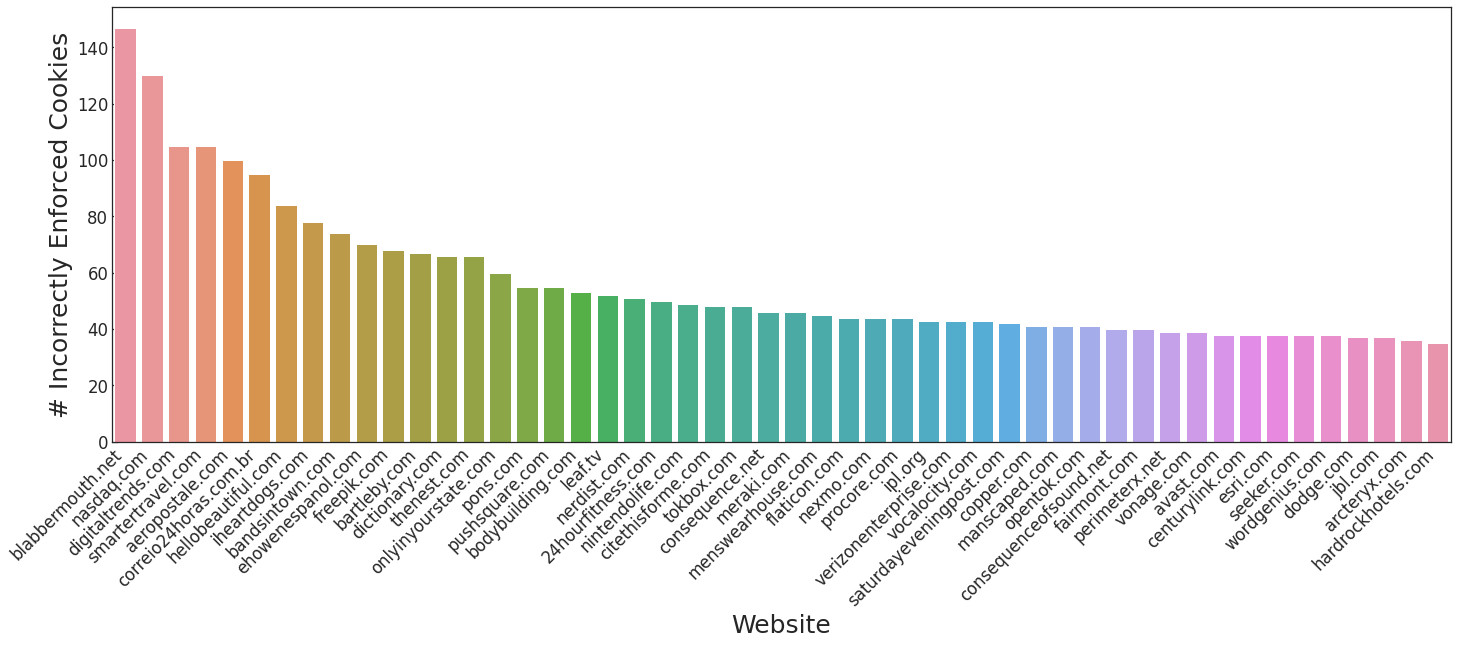

In [136]:
sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x='index', y='site', data=incor_counts)

ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=True, direction="in")
ax.set_ylabel('# Incorrectly Enforced Cookies')
ax.set_xlabel('Website')

out_file = FIG_DIR / 'incor_site.png'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [55]:
# len(incor_counts)

In [56]:
incor_counts[incor_counts.site == 33].reset_index(drop=True)

,index,site


### Top incorrect cookies

In [57]:
incor_cookies = complies[complies.comply == 'incorrect']

In [58]:
# site = 'onetrust.com'
# complies[complies.site == site].reset_index(drop=True)
# cookie_prefs[(cookie_prefs.site == site) & (cookie_prefs.name == '_gid')]

In [59]:
top_incor_cookies = incor_cookies.name.value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index':'cookie_name', 'name': 'num_occur'})

In [60]:
top_incor_cookies['num_sites'] = top_incor_cookies.cookie_name.map(lambda cookie_name: incor_cookies[incor_cookies.name == cookie_name].site.nunique())

In [67]:
print(top_incor_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))

\begin{tabular}{lr}
\toprule
Cookie Name &  \# Websites \\
\midrule
        \_ga &         652 \\
       \_gid &         632 \\
       \_fbp &         432 \\
        IDE &         435 \\
    \_uetsid &         255 \\
\bottomrule
\end{tabular}



# Narrow cookie consent preferences

In [63]:
consent_cookies = sent_cookies[sent_cookies.name.isin(['OptanonConsent', 'CookieConsent'])][['domain', 'name', 'site']].drop_duplicates()
narrow_consent_cookies = consent_cookies[~consent_cookies.domain.str.startswith('.')].reset_index(drop=True)

In [64]:
set(contra_cookies.site).intersection(set(narrow_consent_cookies.site))

{'returnpath.net', 'statista.com', 'validity.com'}

In [65]:
narrow_consent_cookies

,domain,name,site
0,www.ncl.ac.uk,CookieConsent,ncl.ac.uk
1,www.warnerbros.com,OptanonConsent,warnerbros.com
2,www.statista.com,OptanonConsent,statista.com
3,www.frontier.co.uk,CookieConsent,frontier.co.uk
4,www.unibz.it,CookieConsent,unibz.it
...,...,...,...
186,www.fourth.com,CookieConsent,fourth.com
187,plu.mx,OptanonConsent,plu.mx
188,www.norden.org,CookieConsent,norden.org
189,www.vonage.com,OptanonConsent,nexmo.com


# Case studies

In [98]:
incor_df = complies[complies.comply == 'incorrect']
incor_df.site.value_counts().sort_values(ascending=False).head()

blabbermouth.net     147
nasdaq.com           130
smartertravel.com    105
digitaltrends.com    105
aeropostale.com      100
Name: site, dtype: int64

In [124]:
incor_df[incor_df.site == 'scientificamerican.com'].name

359932            SPW_SL
359937    MXP_TRACKINGID
359942      mobileFormat
Name: name, dtype: object

In [130]:
cookie_prefs[(cookie_prefs.site == 'scientificamerican.com') & (cookie_prefs.name == 'MXP_TRACKINGID')]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,MXP_TRACKINGID,scientificamerican.com,10957 days,C0008,Targeting (1st Party),inactive,scientificamerican.com,onetrust,en.json,False


In [133]:
# sent_cookies[(sent_cookies.site == 'scientificamerican.com') & (sent_cookies.name == 'MXP_TRACKINGID')]

In [108]:
omit_df = complies[complies.comply == 'omit']
omit_df.site.value_counts().sort_values(ascending=False).iloc[20:30]

rachaelraymag.com     149
bodybuilding.com      149
ipl.org               148
wordgenius.com        139
hellobeautiful.com    137
leaf.tv               133
thenest.com           116
society6.com          115
manrepeller.com       112
nasdaq.com            111
Name: site, dtype: int64

In [122]:
print(omit_df[omit_df.site == 'scientificamerican.com'].reset_index().name.tolist())

['SA_fonts_loaded', 'cftoken', 'cfid']


In [125]:
'uids' in omit_df[omit_df.site == 'scientificamerican.com'].reset_index().name.tolist()

False

In [128]:
omit_df[(omit_df.site == 'scientificamerican.com') & (omit_df.name == 'cftoken')]

,name,domain,site,comply
359933,cftoken,.scientificamerican.com,scientificamerican.com,omit


In [121]:
cookie_prefs[(cookie_prefs.site == 'scientificamerican.com') & (cookie_prefs.name == 'ADGRX_UID')]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent


In [ ]:
all_sites = set(complies.site)
nothing_comply_sites = all_sites - set(complies[complies.comply == 'comply'].site)
print("Sites with no compliant cookies:", nothing_comply_sites)

In [ ]:
for site in ['liveperson.com']: # nothing_comply_sites:
    print(site)
site_cookies = postrej_br_cookies[postrej_br_cookies.site == site]

In [ ]:
acookie = site_cookies[site_cookies.name == 'OptanonAlertBoxClosed'].iloc[0]

In [ ]:
site_prefs = cookie_prefs[cookie_prefs.site == site]
consent_cookies = site_prefs[site_prefs.consent]
consent_cookie_names = consent_cookies.name
site_cookies[site_cookies.name.isin(consent_cookie_names)]
# cookie_name = 'OptanonAlertBoxClosed'
# cookie_pref = site_prefs[site_prefs.name == cookie_name].iloc[0]
# cookie_pref

In [ ]:
consent_cookies

In [ ]:
import sys; import importlib; importlib.reload(sys.modules['consent.consistency.cookie_pref_match'])
from consent.consistency.cookie_pref_match import cookie_pref_match    
cookie_pref_match(acookie, cookie_pref, site, verbose=2)

In [ ]:
# Analyze Contras